In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import os
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [ ]:
!unzip -u "/content/drive/MyDrive/Dataset.zip" -d "/content/data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Dataset/without_mask/993.png  
  inflating: /content/data/__MACOSX/Dataset/without_mask/._993.png  
  inflating: /content/data/Dataset/without_mask/2098.png  
  inflating: /content/data/__MACOSX/Dataset/without_mask/._2098.png  
  inflating: /content/data/Dataset/without_mask/1591.png  
  inflating: /content/data/__MACOSX/Dataset/without_mask/._1591.png  
  inflating: /content/data/Dataset/without_mask/763.png  
  inflating: /content/data/__MACOSX/Dataset/without_mask/._763.png  
  inflating: /content/data/Dataset/without_mask/2926.png  
  inflating: /content/data/__MACOSX/Dataset/without_mask/._2926.png  
  inflating: /content/data/Dataset/without_mask/2932.png  
  inflating: /content/data/__MACOSX/Dataset/without_mask/._2932.png  
  inflating: /content/data/Dataset/without_mask/777.png  
  inflating: /content/data/__MACOSX/Dataset/without_mask/._777.png  
  inflating: /content/data/Dataset/without_mask/1585

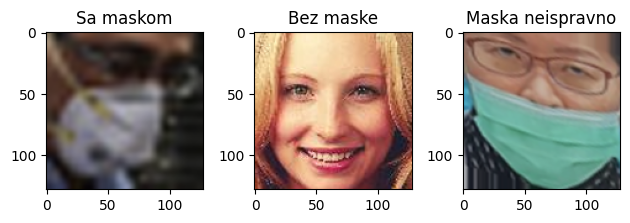

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

slika1 = plt.imread("/content/data/Dataset/with_mask/1001.png")
slika2 = plt.imread("/content/data/Dataset/without_mask/100.png")
slika3 = plt.imread("/content/data/Dataset/mask_weared_incorrect/10.png")

fig = plt.figure()

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(slika1)
ax1.set_title("Sa maskom")

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(slika2)
ax2.set_title("Bez maske")

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(slika3)
ax3.set_title("Maska neispravno")

fig.tight_layout()

# Prikaz grafa
plt.show()


## Dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMAGE_SHAPE = (128,128)
BATCH_SIZE = 32

dataset_path = "/content/data/Dataset"


train_data = tf.keras.utils.image_dataset_from_directory(dataset_path,
                                              shuffle = True,
                                              image_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              label_mode="categorical",
                                              seed=42,
                                              validation_split=0.2,
                                              subset='training',
                                              )


test_data = tf.keras.utils.image_dataset_from_directory(dataset_path,
                                              shuffle = True,
                                              image_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              label_mode="categorical",
                                              seed=42,
                                              validation_split=0.2,
                                              subset='validation',
                                              )

Found 8982 files belonging to 3 classes.
Using 7186 files for training.
Found 8982 files belonging to 3 classes.
Using 1796 files for validation.


In [ ]:
image_batch, label_batch = next(iter(train_data))
label_batch[3]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 0., 0.], dtype=float32)>

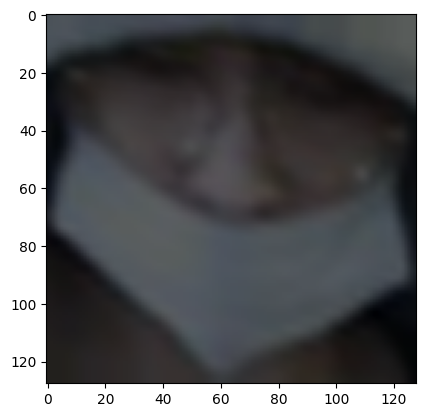

In [ ]:
plt.imshow(image_batch[3]/255)

In [ ]:
import os

def explore_dataset(dataset_path):
    # List the directories in the dataset path
    directories = os.listdir(dataset_path)

    # Create an empty dictionary to store the counts
    class_counts = {}

    # Iterate over each directory
    for directory in directories:
        # Check if the path is indeed a directory
        if os.path.isdir(os.path.join(dataset_path, directory)):
            # Count the number of files in the directory
            num_files = len(os.listdir(os.path.join(dataset_path, directory)))

            # Add the count to the dictionary
            class_counts[directory] = num_files

    return class_counts

# Now, call this function with your dataset path
class_counts = explore_dataset(dataset_path)

# And print the results
for class_name, count in class_counts.items():
    print(f"There are {count} items in the class {class_name}")


There are 2994 items in the class without_mask
There are 2994 items in the class mask_weared_incorrect
There are 2994 items in the class with_mask


## Define My Model

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras import layers, models


data_augmentation = models.Sequential([
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal")
], name="data_augmentation")

model = models.Sequential([
        layers.Input(shape=(128, 128, 3)),
        data_augmentation,
        Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Dropout(0.3),
        Conv2D(64, kernel_size=(5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2),strides=2),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                 patience=7)
callbacks_list = [reduce_lr, early_stopping]

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

# Fit the model
history = model.fit(train_data,
                      epochs=50,
                      validation_data=test_data,
                      validation_steps=int(.5*len(test_data)),
                      callbacks=callbacks_list)

Epoch 1/50
225/225 [==============================] - 21s 44ms/step - loss: 0.5132 - accuracy: 0.8087 - val_loss: 0.7690 - val_accuracy: 0.7645 - lr: 1.0000e-04
Epoch 2/50
225/225 [==============================] - 8s 35ms/step - loss: 0.2485 - accuracy: 0.9089 - val_loss: 0.3481 - val_accuracy: 0.9129 - lr: 1.0000e-04
Epoch 3/50
225/225 [==============================] - 9s 41ms/step - loss: 0.1708 - accuracy: 0.9371 - val_loss: 0.1810 - val_accuracy: 0.9342 - lr: 1.0000e-04
Epoch 4/50
225/225 [==============================] - 10s 42ms/step - loss: 0.1286 - accuracy: 0.9531 - val_loss: 0.1195 - val_accuracy: 0.9643 - lr: 1.0000e-04
Epoch 5/50
225/225 [==============================] - 7s 32ms/step - loss: 0.0955 - accuracy: 0.9666 - val_loss: 0.0796 - val_accuracy: 0.9821 - lr: 1.0000e-04
Epoch 6/50
225/225 [==============================] - 8s 34ms/step - loss: 0.0770 - accuracy: 0.9738 - val_loss: 0.0961 - val_accuracy: 0.9754 - lr: 1.0000e-04
Epoch 7/50
225/225 [==================

In [ ]:
model.evaluate(test_data)

57/57 [==============================] - 2s 25ms/step - loss: 0.0562 - accuracy: 0.9850


[0.05619591474533081, 0.9849665760993958]

In [ ]:
model.save('my_model.h5')

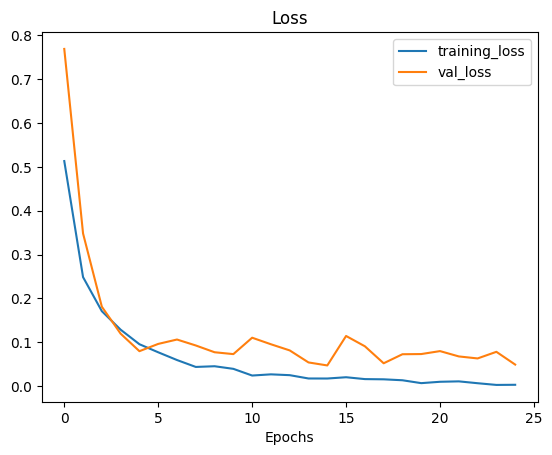

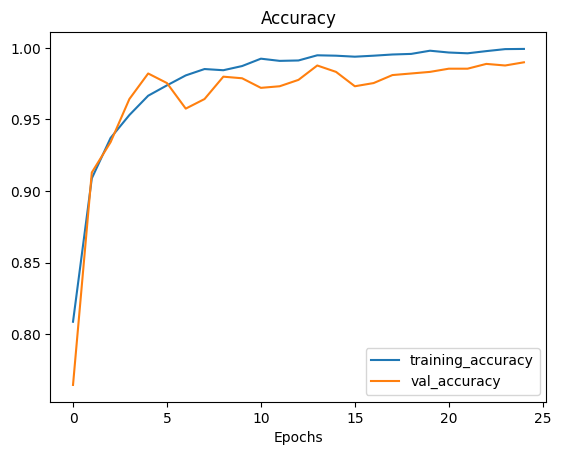

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

1/1 [==============================] - 0s 19ms/step
1


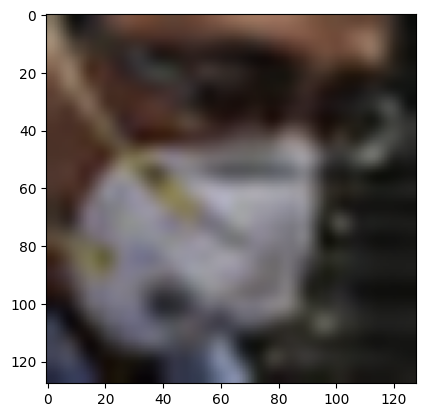

In [ ]:
import cv2

# Load the image
image = cv2.imread('/content/data/Dataset/with_mask/1001.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Resize the image
resized_image = cv2.resize(image, (128, 128))
preds = model.predict(tf.expand_dims(resized_image,axis=0))
print(np.argmax(preds))

plt.imshow(resized_image)

In [ ]:
import time

start_time = time.time()
preds = model.predict(tf.expand_dims(resized_image,axis=0))
end_time = time.time()

elapsed_time = end_time - start_time

print(f'Time elapsed for prediction: {elapsed_time} seconds')

1/1 [==============================] - 0s 22ms/step
Time elapsed for prediction: 0.07102108001708984 seconds


## VGG-16

In [ ]:
base_model = tf.keras.applications.vgg16.VGG16(include_top=False)
base_model.trainable=False
inputs = layers.Input(shape=(128,128,3),name="input_layer")
x= data_augmentation(inputs)
x= base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(3,activation="softmax")(x)
model = tf.keras.Model(inputs,outputs)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                 patience=7)
callbacks_list = [reduce_lr, early_stopping]

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

# Fit the model
history = model.fit(train_data,
                      epochs=50,
                      validation_data=test_data,
                      validation_steps=int(.5*len(test_data)),
                      callbacks=callbacks_list)

Epoch 1/50
225/225 [==============================] - 9s 30ms/step - loss: 1.0893 - accuracy: 0.5166 - val_loss: 0.9745 - val_accuracy: 0.6138 - lr: 1.0000e-04
Epoch 2/50
225/225 [==============================] - 8s 35ms/step - loss: 0.9085 - accuracy: 0.6606 - val_loss: 0.8527 - val_accuracy: 0.6830 - lr: 1.0000e-04
Epoch 3/50
225/225 [==============================] - 7s 31ms/step - loss: 0.8055 - accuracy: 0.7214 - val_loss: 0.7705 - val_accuracy: 0.7098 - lr: 1.0000e-04
Epoch 4/50
225/225 [==============================] - 7s 30ms/step - loss: 0.7296 - accuracy: 0.7547 - val_loss: 0.7057 - val_accuracy: 0.7533 - lr: 1.0000e-04
Epoch 5/50
225/225 [==============================] - 9s 37ms/step - loss: 0.6693 - accuracy: 0.7804 - val_loss: 0.6587 - val_accuracy: 0.7723 - lr: 1.0000e-04
Epoch 6/50
225/225 [==============================] - 7s 30ms/step - loss: 0.6223 - accuracy: 0.8002 - val_loss: 0.6196 - val_accuracy: 0.7868 - lr: 1.0000e-04
Epoch 7/50
225/225 [====================

In [ ]:
model.evaluate(test_data)

57/57 [==============================] - 2s 28ms/step - loss: 0.2555 - accuracy: 0.9120


[0.25554150342941284, 0.9120267033576965]

In [ ]:
model.save('vgg.h5')

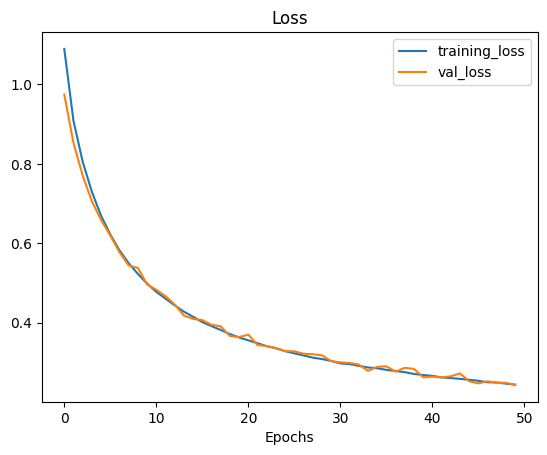

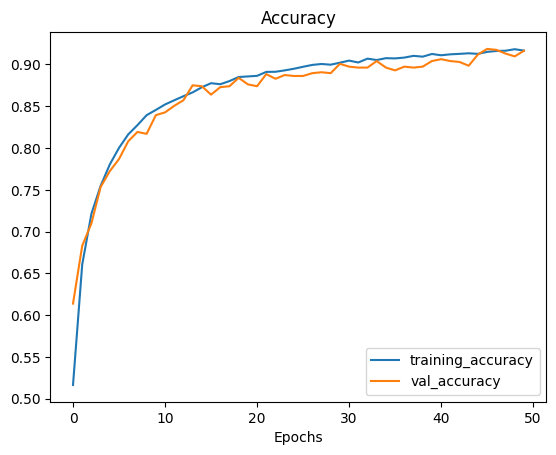

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [ ]:
import time

start_time = time.time()
preds = model.predict(tf.expand_dims(resized_image,axis=0))
end_time = time.time()

elapsed_time = end_time - start_time

print(f'Time elapsed for prediction: {elapsed_time} seconds')

1/1 [==============================] - 0s 398ms/step
Time elapsed for prediction: 0.44737696647644043 seconds


## MobileNET

In [ ]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=(128,128,3))
base_model.trainable=False
inputs = layers.Input(shape=(128,128,3),name="input_layer")
x= data_augmentation(inputs)
x= base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(3,activation="softmax")(x)
model_mob = tf.keras.Model(inputs,outputs)

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                 patience=7)
callbacks_list = [reduce_lr, early_stopping]

model_mob.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

# Fit the model
history = model_mob.fit(train_data,
                      epochs=50,
                      validation_data=test_data,
                      validation_steps=int(.5*len(test_data)),
                      callbacks=callbacks_list)

Epoch 1/50
225/225 [==============================] - 14s 47ms/step - loss: 0.6934 - accuracy: 0.7110 - val_loss: 0.4148 - val_accuracy: 0.8415 - lr: 1.0000e-04
Epoch 2/50
225/225 [==============================] - 7s 32ms/step - loss: 0.3557 - accuracy: 0.8755 - val_loss: 0.2892 - val_accuracy: 0.9040 - lr: 1.0000e-04
Epoch 3/50
225/225 [==============================] - 8s 34ms/step - loss: 0.2734 - accuracy: 0.9079 - val_loss: 0.2411 - val_accuracy: 0.9208 - lr: 1.0000e-04
Epoch 4/50
225/225 [==============================] - 9s 38ms/step - loss: 0.2330 - accuracy: 0.9197 - val_loss: 0.2020 - val_accuracy: 0.9364 - lr: 1.0000e-04
Epoch 5/50
225/225 [==============================] - 9s 40ms/step - loss: 0.2055 - accuracy: 0.9317 - val_loss: 0.1845 - val_accuracy: 0.9475 - lr: 1.0000e-04
Epoch 6/50
225/225 [==============================] - 8s 34ms/step - loss: 0.1806 - accuracy: 0.9381 - val_loss: 0.1776 - val_accuracy: 0.9520 - lr: 1.0000e-04
Epoch 7/50
225/225 [===================

In [ ]:
model_mob.evaluate(test_data)

57/57 [==============================] - 2s 27ms/step - loss: 0.0608 - accuracy: 0.9800


[0.06083056703209877, 0.9799554347991943]

In [ ]:
model_mob.save('mobnetv2.h5')

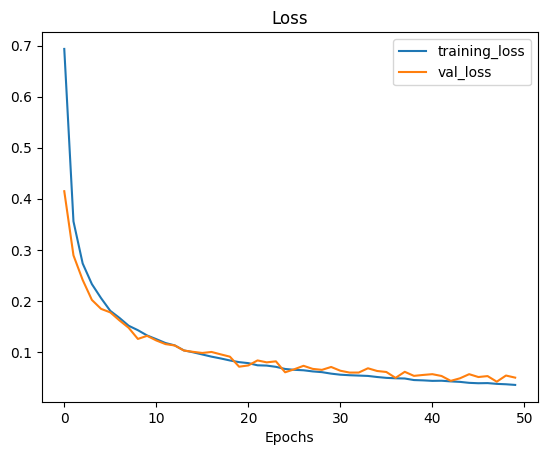

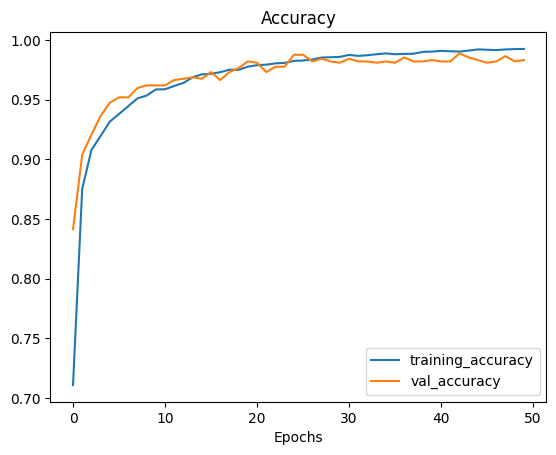

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [ ]:
import time

start_time = time.time()
preds = model_mob.predict(tf.expand_dims(resized_image,axis=0))
end_time = time.time()

elapsed_time = end_time - start_time

print(f'Time elapsed for prediction: {elapsed_time} seconds')

1/1 [==============================] - 0s 28ms/step
Time elapsed for prediction: 0.07407832145690918 seconds
